In [ ]:
import plotnine as p9
import numpy as np
import pandas as pd
import scipy.sparse as sp
from load_cluster_data import load_cluster_data
from binomial_ZI import binomial_ZI

input_file = '/gpfs/commons/groups/knowles_lab/Karin/parse-pbmc-leafcutter/leafcutter/junctions/PBMC_input_for_LDA.h5'

final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data(
    input_file)

ind = (final_data['cell_id_index'].values, final_data['junction_id_index'].values)


/gpfs/commons/home/daknowles/calcutta/leafcutter-sc/src/beta-binomial-lda/binomial_ZI.py:23: RuntimeWarning: divide by zero encountered in log1p
/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10


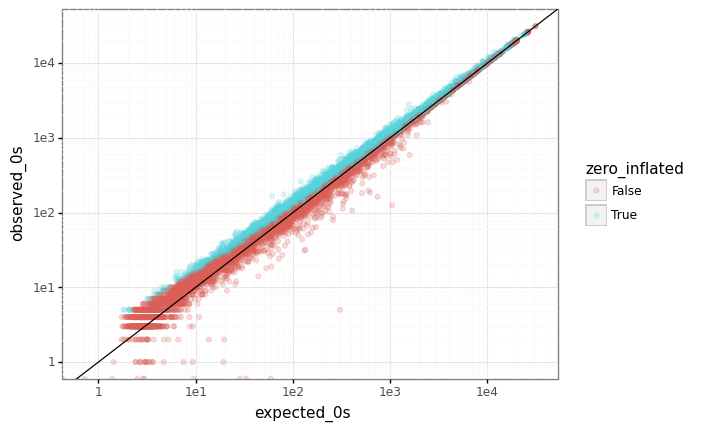

<ggplot: (8756463424452)>

In [6]:
y_all = sp.coo_matrix( (final_data.junc_count.values, ind ))
n_all = sp.coo_matrix( (final_data.cluster_count.values, ind ))
nz_all = sp.coo_matrix( (np.ones(final_data.shape[0]), ind ))

y_csr = y_all.tocsr()
n_csr = n_all.tocsr()
nz_csr = nz_all.tocsr()

to_plot = binomial_ZI(y_csr, n_csr, nz_csr)

ziplot = ( p9.ggplot(to_plot, p9.aes(x="expected_0s", y="observed_0s", color="zero_inflated")) + p9.geom_point(alpha=0.2) + p9.geom_abline(intercept=0,slope=1) + p9.scale_x_log10() + p9.scale_y_log10() + p9.themes.theme_bw())
ziplot

In [11]:
zi_rate = {}
for celltype in cell_ids_conversion.cell_type.unique(): 
    cell_type_rows = (cell_ids_conversion.cell_type == celltype).to_numpy()
    if cell_type_rows.sum() < 500: 
        print("Skipping", celltype)
        continue
        
    print(celltype)

    to_plot = binomial_ZI.binomial_ZI(
        y_csr[cell_type_rows,:],
        n_csr[cell_type_rows,:],
        nz_csr[cell_type_rows,:]
    )
    zi_rate[celltype] = np.mean(to_plot.zero_inflated)

    ziplot = ( p9.ggplot(to_plot, p9.aes(x="expected_0s", y="observed_0s", color="zero_inflated")) + p9.geom_point(alpha=0.2) + p9.geom_abline(intercept=0,slope=1) + p9.scale_x_log10() + p9.scale_y_log10() + p9.themes.theme_bw() + p9.ggtitle(celltype + " cells"))
    #ziplot
    #p9.ggsave(ziplot, "figs/zi_binomial_%s.png" % celltype, figsize=(5,4))


B


/gpfs/commons/home/daknowles/calcutta/leafcutter-sc/src/beta-binomial-lda/binomial_ZI.py:23: RuntimeWarning: divide by zero encountered in log1p


CD14Mono
CD8T
DC
FCGR3A
Skipping IGHA
MemoryCD4T
NK
NaiveCD4T
Skipping ZNF385D


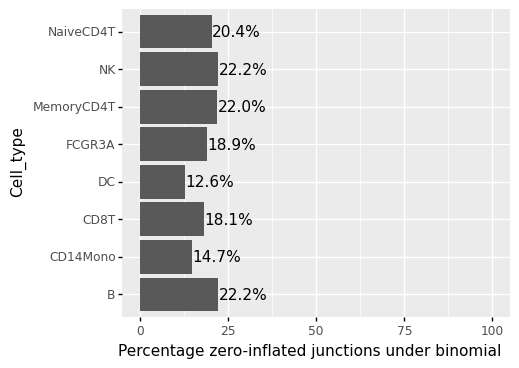

<ggplot: (8756483347011)>

In [15]:

zi_rate_df = pd.DataFrame({"Cell_type":zi_rate.keys(), "ZI_rate":zi_rate.values()})
zi_rate_df["ZI_rate"] = 100. * zi_rate_df["ZI_rate"]
zi_summary = p9.ggplot(zi_rate_df, p9.aes("Cell_type", "ZI_rate", label="ZI_rate")) + p9.geom_col() + p9.geom_text(format_string="{:.1f}%", nudge_y = 7) + p9.coord_flip(ylim=[0,100]) + p9.ylab("Percentage zero-inflated junctions under binomial") + p9.theme(figure_size=(5,4))
zi_summary
#p9.ggsave(zi_summary, "figs/zi_summary.pdf")

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10


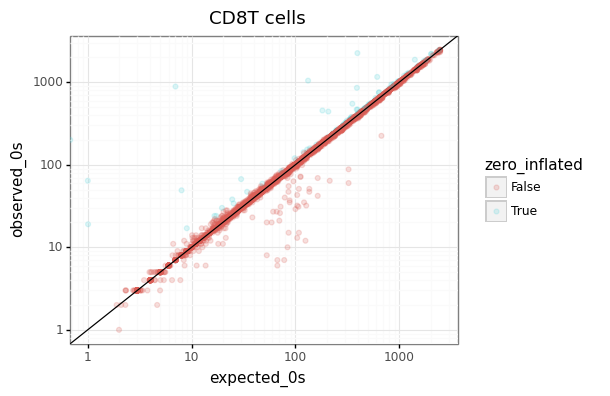

<ggplot: (8756482586841)>

In [17]:

celltype = "CD8T"

karin_bb = pd.read_csv("/gpfs/commons/groups/knowles_lab/Karin/parse-pbmc-leafcutter/leafcutter/Clusters_ZI_results.csv.gz")

karin_bb["zero_inflated"] = karin_bb.obtained_zeroes > karin_bb.expected_upper_bount
karin_cd8T = karin_bb[karin_bb.cell == celltype]

ziplot = ( p9.ggplot(karin_cd8T, p9.aes(x="pois_bern_mean", y="obtained_zeroes", color="zero_inflated")) + p9.geom_point(alpha=0.2) + p9.geom_abline(intercept=0,slope=1) + p9.scale_x_log10() + p9.scale_y_log10() + p9.themes.theme_bw() + p9.xlab("expected_0s") + p9.ylab("observed_0s") + p9.ggtitle(celltype + " cells")) + p9.theme(figure_size=(5,4))
ziplot
#p9.ggsave(ziplot, "figs/zi_bb.pdf")




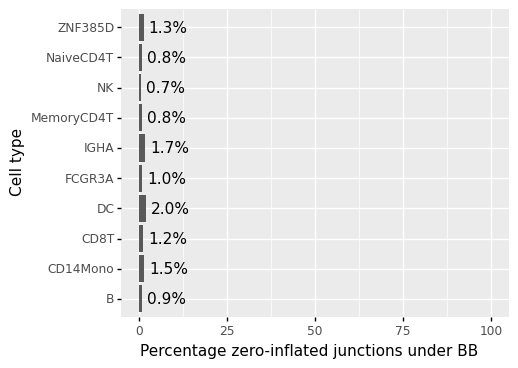

<ggplot: (8756483332943)>

In [18]:
zi_bb_rate_df = karin_bb.groupby("cell", as_index=False).agg({"zero_inflated":"mean"})
zi_bb_rate_df["zero_inflated"] = 100. * zi_bb_rate_df["zero_inflated"]
zi_summary = p9.ggplot(zi_bb_rate_df, p9.aes("cell", "zero_inflated", label="zero_inflated")) + p9.geom_col() + p9.geom_text(format_string="{:.1f}%", nudge_y = 7) + p9.coord_flip(ylim=[0,100]) + p9.ylab("Percentage zero-inflated junctions under BB") + p9.xlab("Cell type") + p9.theme(figure_size=(5,4))
zi_summary
#p9.ggsave(zi_summary, "figs/zi_bb_summary.pdf")
